# install dependency 


In [156]:
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
import tensorflow_io as tfio 

# 2) building data loading function

In [157]:
BASE = os.path.join("data")
one_file = os.path.join(BASE,"Parsed_Capuchinbird_Clips")
zero_file = os.path.join(BASE,"Parsed_Not_Capuchinbird_Clips")

In [158]:
ex1 = os.path.join(one_file,"XC3776-0.wav")
ex0 = os.path.join(zero_file, "afternoon-birds-song-in-forest-0.wav")

### building fucntion to laod the data

In [159]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

In [160]:
file_contents = tf.io.read_file(ex1)
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)

In [161]:
print(wav)

tf.Tensor(
[[-0.1289978 ]
 [-0.15133667]
 [-0.14691162]
 ...
 [ 0.11514282]
 [ 0.10748291]
 [ 0.1100769 ]], shape=(132300, 1), dtype=float32)


In [162]:
import librosa

#function to sample the audio file
def load_wav_16k_mono(filename):
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    return wav

In [163]:
# ploating the wave
wave = load_wav_16k_mono(ex1)
nwave = load_wav_16k_mono(ex0)


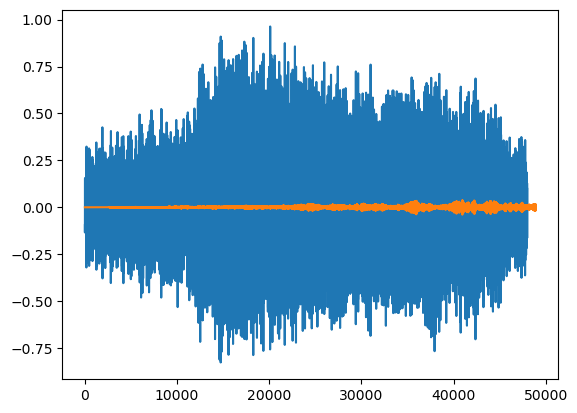

In [164]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## creating a tensorflow dataset

In [165]:
#defining the dataset path
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NOS = os.path.join('data','Parsed_Not_Capuchinbird_Clips')


In [166]:
#creating tensorflow dataset
pos = tf.data.Dataset.list_files(POS+'/*.wav')
nos = tf.data.Dataset.list_files(NOS+'/*.wav')

In [167]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC44070-0.wav'

In [168]:
# adding labels and positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((nos, tf.data.Dataset.from_tensor_slices(tf.ones(len(nos)))))
data = positives.concatenate(negatives)

In [169]:
positives.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC388470-5.wav', 1.0)

In [170]:
negatives.as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/screech-owl-sounds-at-night-5.wav', 1.0)

## 4) determining each call

In [171]:
# calculating wave cycle length
lengths = []
for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file ))
    lengths.append(len(tensor_wave))

In [172]:
cycle_value = tf.math.reduce_mean(lengths)

In [173]:
print(f"the average call is of {cycle_value/16000} seconds.")

the average call is of 3.38475 seconds.


In [174]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [175]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

## function to convert to spectrogram

In [186]:
def preprocess(file_path, label):
    # Load the audio waveform as a 1D tensor
    wav = load_wav_16k_mono(file_path)
    
    # Truncate the waveform if it's longer than 48000 samples
    wav = wav[:48000]

    # Get the current length of the waveform
    wav_length = tf.shape(wav)[0]

    # Calculate the padding needed to make the waveform 48000 samples long
    padding_needed = 48000 - wav_length

    # If padding is needed, create a tensor of zeros and concatenate to the wav
    zero_padding = tf.zeros([padding_needed], dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], axis=0)

    # Compute the Short-Time Fourier Transform (STFT) of the waveform
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)

    # Take the absolute value of the spectrogram to get the magnitude
    spectrogram = tf.abs(spectrogram)

    # Expand dimensions to add a channel dimension (for use in CNNs)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    return spectrogram, tf.convert_to_tensor(label)

### 5.1) testing out the function and visualising the spectrogram

In [187]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [188]:
spectrogram, label = preprocess(filepath, label)

In [190]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[2.0149471e-02],
        [7.5148508e-02],
        [7.5460315e-02],
        ...,
        [3.6106982e-07],
        [4.2556150e-07],
        [1.2479722e-07]],

       [[8.9499637e-02],
        [9.4117269e-02],
        [5.8869820e-02],
        ...,
        [3.9298723e-07],
        [4.9387853e-07],
        [2.6077032e-08]],

       [[1.4422990e-01],
        [1.2542994e-01],
        [7.4645258e-02],
        ...,
        [2.6782124e-07],
        [3.4659217e-07],
        [1.9371510e-07]],

       ...,

       [[5.2566193e-02],
        [6.1061323e-02],
        [8.1157342e-02],
        ...,
        [4.7429836e-07],
        [2.5008049e-07],
        [6.2026083e-07]],

       [[5.4389082e-02],
        [6.9680966e-02],
        [9.8013319e-02],
        ...,
        [4.3573158e-07],
        [3.4333860e-07],
        [4.9918890e-07]],

       [[3.8624663e-02],
        [6.7238435e-02],
        [1.0242188e-01],
        ...,
        [2.2728135

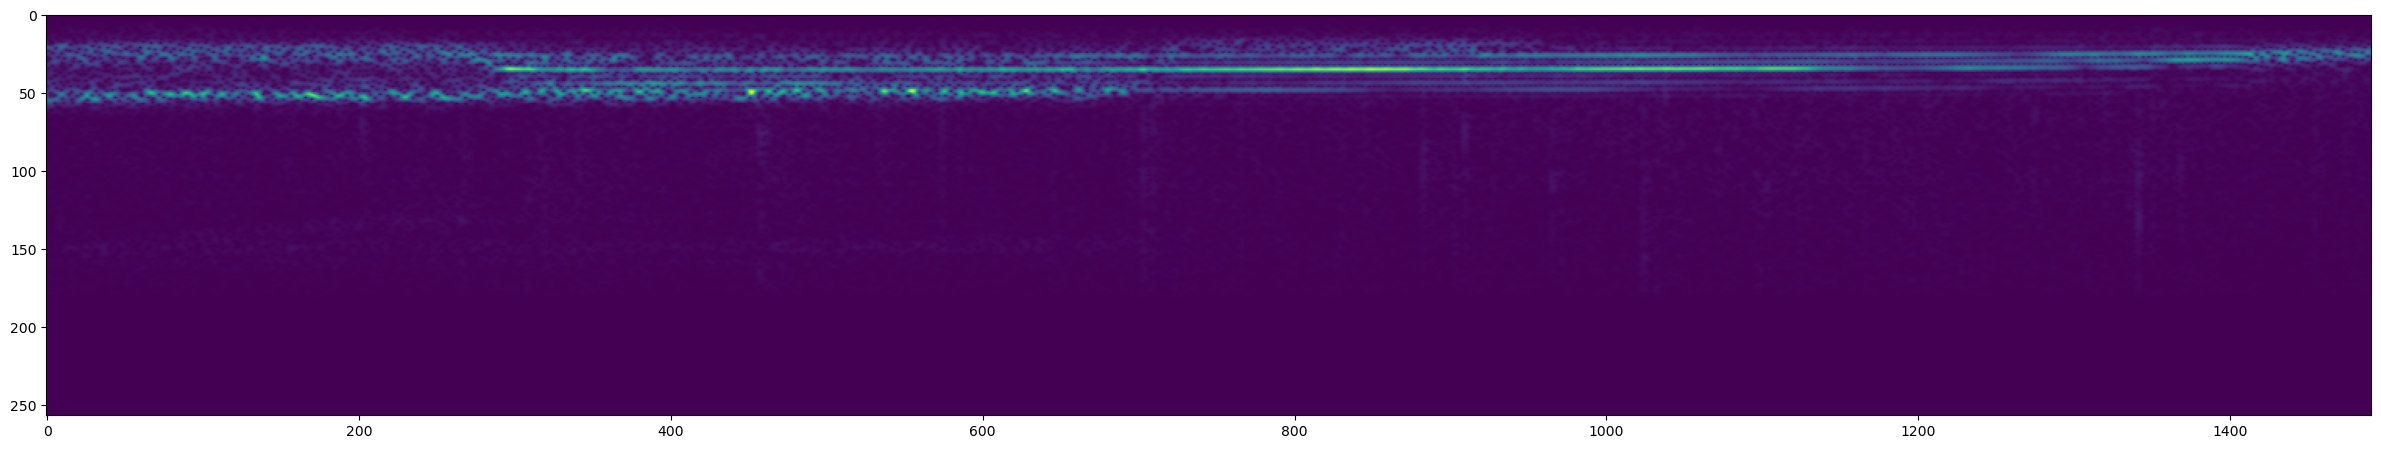

In [180]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6)creating training and testing prtition

### 6.1) creating tensorflow data pipeline

In [181]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

TypeError: in user code:

    File "/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_9398/1771690273.py", line 3, in preprocess  *
        wav = load_wav_16k_mono(file_path)
    File "/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_9398/274979017.py", line 5, in load_wav_16k_mono  *
        wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/audio.py", line 176, in load  *
        y, sr_native = __soundfile_load(path, offset, duration, dtype)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/audio.py", line 209, in __soundfile_load  *
        context = sf.SoundFile(path)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/soundfile.py", line 658, in __init__  **
        self._file = self._open(file, mode_int, closefd)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/soundfile.py", line 1212, in _open
        raise TypeError("Invalid file: {0!r}".format(self.name))

    TypeError: Invalid file: <tf.Tensor 'args_0:0' shape=() dtype=string>


tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC79965-7.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC79965-6.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC98557-0.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC98557-1.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC216012-18.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC201990-0.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC307385-4.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC216012-4.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC216010-1.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC46077-0.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC22397-4.wav', shape=(), dtype=string)
tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC27882-5.wav', shape=(), dtype=string

2024-09-21 14:12:02.332030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
